In [120]:
import argparse
from ucbq_agent import UCBQAgent
from ucbq_environment import ModifiedRandomEnvironment
import time
import numpy as np

In [121]:
# TODO:
# how do we set these?
ERR_P = 0.2
ERR_N = 0.4

class PreProcessor:
    "Add noise to reward"
    def __init__(self, e_=0.1, e=0.3, normal=True, epsilon=1e-6):
        assert (np.abs(e_ + e - 1) > epsilon)
        self.normal = normal
        self.e_ = e_
        self.e = e
        self.epsilon = 1e-6
        # These are the noisy returns that are returned
        self.r1 = -1
        self.r2 = 0

    def noisy_reward(self, reward):
        n = np.random.random()
        # If we hit a negative reward, conver it to a poisitive
        # with a given prob. 
        # Not sure why the `< epsilone is here`
        # if np.abs(reward - self.r1) < self.epsilon:
        if reward == self.r1:
            if (n < self.e_):
                return self.r2
        else:
            if (n < self.e):
                return self.r1
        return reward

    def process_reward(self, reward):
        if self.normal:
            return reward

        r = self.noisy_reward(reward)
        return r
    
pre_processor = PreProcessor(normal=False, e_=ERR_N, e=ERR_P)

In [122]:
class PostProcessor:
    """
    Learning from surrogate reward
    following paper "Learning from noisy labels"
    """
    def __init__(self, smooth=False, surrogate=True,reverse=False, epsilon=1e-6):
        self.surrogate = surrogate
        self.smooth = smooth
        self.r_sets = {}
        self.r_smooth = {}
        self.r1 = -1
        self.r2 = 0
        self.counter = 0
        self.C = np.identity(2)
        self.epsilon = epsilon
        self.reverse = reverse

    def process_reward(self, reward):
        self.estimate_C()
        self.e_ = self.C[0, 1]
        self.e = self.C[1, 0]

        if self.surrogate:
            if np.abs(reward - self.r1) < self.epsilon:
                reward = ((1 - self.e) * self.r1 - self.e_ * self.r2) / (1 - self.e_ - self.e)
            else:
                reward = ((1 - self.e_) * self.r2 - self.e * self.r1) / (1 - self.e_ - self.e)

        return reward

    def estimate_C(self):
        if self.counter >= 100 and self.counter % 100 == 0:
            e_ = 0; e = 0
            # a = 0; b = 0
            # prob = 0

            self.count1 = 0
            self.count2 = 0
            for k in self.r_sets.keys():
                freq_count = collections.Counter(self.r_sets[k])
                if self.reverse:
                    truth, count = freq_count.most_common()[-1]
                else: truth, count = freq_count.most_common()[0]
                if truth == self.r1:
                    self.count1 += len(self.r_sets[k])
                else:
                    self.count2 += len(self.r_sets[k])

            for k in self.r_sets.keys():
                freq_count = collections.Counter(self.r_sets[k])
                # if self.e_ > 0.05:
                #    self.reverse = True
                #    self.counter = 0; self.r_sets = {}
                #    break

                if self.reverse:
                    truth, count = freq_count.most_common()[-1]
                else:
                    truth, count = freq_count.most_common()[0]
                prob_correct = float(count) / len(self.r_sets[k])
                if truth == self.r1:
                    if self.count1 > 2000:
                        prob_k = float(len(self.r_sets[k])) / self.count1
                        e_ += prob_k * (1 - prob_correct)
                    else: e_ = 0.0
                    # a += 2 * prob_k * prob_correct
                else:
                    prob_k = float(len(self.r_sets[k])) / self.count2
                    e += prob_k * (1 - prob_correct)
                    # b += 2 * prob_k * prob_correct

            # print prob
            # log_string(str(e_) + " " + str(e))
            self.C = np.array([[1-e_, e_], [e, 1-e]])

            # if self.counter >= 10000:
            #     self.counter = 0
            #    self.r_sets = {}

            # print self.C

    def smooth_reward(self, state, action, reward):
        if self.smooth:
            if (state, action) in self.r_smooth:
                if len(self.r_smooth[(state, action)]) >= 100:
                    self.r_smooth[(state, action)].pop(0)
                    self.r_smooth[(state, action)].append(reward)
                    return sum(self.r_smooth[(state, action)]) / float(len(self.r_smooth[(state, action)]))
                else:
                    self.r_smooth[(state, action)].append(reward)
            else:
                self.r_smooth[(state, action)] = [reward]

        return reward

    def collect(self, state, action, reward):
        if (state, action) in self.r_sets:
            self.r_sets[(state, action)].append(reward)
        else:
            self.r_sets[(state, action)] = [reward]
        self.counter += 1

#TODO:
# Not sure if we need smoothing
post_processor = PostProcessor(smooth=True, surrogate=True)

In [123]:
all_chart_values = []

In [124]:
# Run the script with
# `python run_experiment.py -t 1`
# This will run a simulation trial, with a total length of 1 seconds.
# Participant answere will be given every 0.001 to 0.002 seconds.
# The participant "ture" level of feedback is 2.

# The script will output:
# - A list of actions taken, in the format: 
# `elapsed_time > action_taken -> reward_received`
# - The Q-table at the end of the trial,
# with rows representing states and columns representing acions
# - The total count of given actions taken in a given state, 
# with rows representing states and columns representing acions
# - Total timesteps (actions) taken
# - Total reward obtained

# The agent is rewrded `-1` for guessing the wrong feedback level (not 2),
# and `0` for guessing correctly

# parser = argparse.ArgumentParser()
# parser.add_argument("-t", "--TimeOut", help = "Stop script after n seconds")
# args = parser.parse_args()
timeOut = 10
num_states = 10
start_state = 1

In [125]:
import matplotlib.pyplot as plt

In [126]:
def runner(adjust_rewards=None):
    agent = UCBQAgent(num_states=num_states, num_actions=num_states)
    env = ModifiedRandomEnvironment(current_state = start_state, num_states=num_states)

    start_time = time.time()
    t = 0

    episode_rewards = 0

    q_values_for_chart = []
    rewards = []

    state = start_state

    while True:
        elapsed_time = time.time() - start_time

        # Auto shut down scipt 
        if bool(timeOut) and (elapsed_time > float(timeOut)):
            break

        action = agent.choose_action(state) 
        # TODO: 
        # send_action_to_stream
        reward, next_state = env.step(action)
        
        rewards.append(reward)

        if adjust_rewards:
            reward = adjust_rewards(reward, state, action)
        
        # print(f"{round(elapsed_time, 2)} > {action} -> {reward}")
        
        agent.learn(state, action, reward, next_state)
        state = next_state

        episode_rewards += reward

        t += 1

        # Decay epsilon every 10 steps
        # TODO: not sure if this is valid theoretically
        if t % 10 == 0:
            if agent.epsilon > agent.epsilon_min:
                agent.epsilon *= agent.epsilon_decay # Decay epsilon
            
        if t % 10 == 0:
            q_values_for_chart.append(np.around(np.sum(agent.Q, axis=0), decimals=4))

    print(f'Q-table:')
    print(f'{np.around(agent.Q, decimals=4)}')
    print(f'Number of times action was taken:')
    print(f'{agent.N}')
    print(f'Total timesteps: {sum(sum(agent.N)) - 100}')
    print(f'Episode rewards: {episode_rewards}')

    # plt.plot(q_values_for_chart)
    fig = plt.gcf()
    fig.set_size_inches(18, 4)
    plt.plot(rewards)

    all_chart_values.append(q_values_for_chart)    

# Real rewards UCB Q-learning

Q-table:
[[-0.9688 -0.9375  0.     -0.9375 -0.9375 -0.9375 -0.9375 -0.9375 -0.9375
  -0.9688]
 [-0.9375 -0.9375  0.     -0.9375 -0.9375 -0.9375 -0.9688 -0.9375 -0.9375
  -0.9688]
 [-1.     -1.      0.     -1.     -1.     -1.     -1.     -1.     -1.
  -1.    ]
 [-0.9375 -0.9375  0.     -0.9844 -0.9375 -0.9375 -0.9688 -0.9375 -0.9375
  -0.9375]
 [-0.9688 -0.9375  0.     -0.9375 -0.9375 -0.9375 -0.9375 -0.9375 -0.9375
  -0.9688]
 [-0.9375 -0.9375  0.     -0.9375 -0.9375 -0.9375 -0.9375 -0.9375 -0.9688
  -0.9375]
 [-0.9375 -0.9844  0.     -0.9844 -0.9375 -0.9375 -0.9375 -0.9375 -0.9375
  -0.9688]
 [-0.9375 -0.9375  0.     -0.9375 -0.9375 -0.9375 -0.9375 -0.9375 -0.9375
  -0.9375]
 [-0.9375 -0.9375  0.     -0.9375 -0.9375 -0.9375 -0.9375 -0.9688 -0.9375
  -0.9688]
 [-0.9844 -0.9375  0.     -0.9375 -0.9375 -0.9375 -0.9375 -0.9844 -0.9375
  -0.9375]]
Number of times action was taken:
[[   6.    5.   49.    5.    5.    5.    5.    5.    5.    6.]
 [   5.    5.   39.    5.    5.    5.    6.    

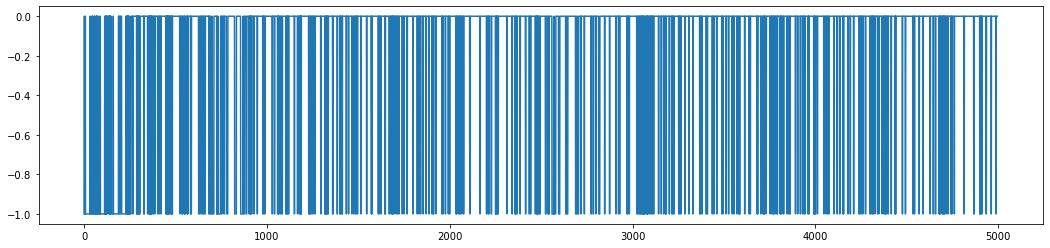

In [127]:
runner()

# Noisy rewards
- rewards are now noisy
- q-learner hasn't changed

Q-table:
[[-5.1119 -4.9909 -4.8458 -4.923  -4.7593 -5.2151 -4.9705 -5.3252 -4.9417
  -5.1688]
 [-5.0286 -5.3547 -4.9555 -5.264  -5.159  -5.2242 -5.249  -5.197  -5.1821
  -5.3653]
 [-5.5003 -5.3109 -4.8502 -5.258  -5.2249 -5.3903 -5.3459 -5.264  -5.24
  -5.2373]
 [-5.0906 -5.1654 -4.9776 -5.1459 -5.2269 -5.1945 -5.2287 -5.1926 -5.0558
  -5.2768]
 [-5.2499 -5.1885 -4.7493 -5.2202 -5.3471 -5.1941 -5.2369 -5.1658 -5.2064
  -5.3431]
 [-5.1291 -5.3011 -4.8914 -5.1618 -5.1704 -5.2959 -5.2841 -5.3958 -5.3304
  -5.167 ]
 [-4.7998 -5.2781 -5.0055 -5.3069 -4.995  -5.3425 -5.1105 -5.2404 -5.2022
  -5.0906]
 [-5.2143 -5.1286 -4.6065 -5.1896 -5.1223 -5.1648 -5.2931 -5.2856 -5.0419
  -5.1566]
 [-5.1772 -5.3751 -4.7778 -5.2355 -5.0994 -5.0397 -5.2279 -5.1144 -5.2816
  -5.1198]
 [-5.2579 -5.1477 -4.9373 -5.2057 -5.1962 -5.3194 -4.7484 -5.4375 -5.3735
  -5.3175]]
Number of times action was taken:
[[  21.   33.   50.   29.   32.   30.   33.   30.   30.   34.]
 [  28.   27.  100.   30.   34.   44.   33.  

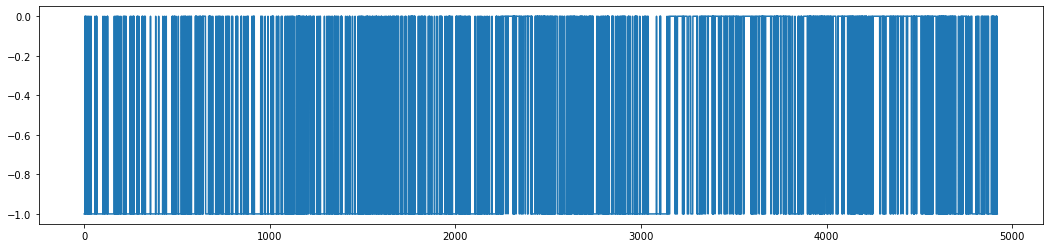

In [128]:
def adjust_rewards_noisy(reward, state, action):
    reward = pre_processor.process_reward(reward)
    reward = post_processor.smooth_reward(state, action, reward)
    return reward

runner(adjust_rewards_noisy)

# Surrogate rewards

In [129]:
import collections

Q-table:
[[-5.3089 -5.3648 -4.8591 -5.2105 -5.2716 -5.3247 -5.1959 -5.2815 -5.3241
  -5.1935]
 [-5.2287 -5.2463 -4.8831 -5.1149 -5.1579 -5.2556 -5.2489 -5.2261 -5.178
  -5.159 ]
 [-5.1806 -5.2342 -4.4208 -5.1823 -5.1922 -5.1287 -5.1977 -5.2025 -5.2811
  -5.1442]
 [-5.186  -5.1422 -4.6353 -5.1537 -5.3537 -5.205  -5.3133 -5.2414 -5.2728
  -5.1535]
 [-5.2751 -5.3093 -4.8022 -5.1729 -5.2905 -5.0705 -5.0387 -5.1819 -5.4221
  -5.1032]
 [-4.827  -5.1394 -4.8023 -5.2706 -5.204  -5.2874 -5.1621 -5.2464 -5.13
  -5.2912]
 [-5.2363 -5.1512 -4.8307 -5.283  -5.2293 -5.0874 -5.2444 -5.1972 -5.1459
  -5.1744]
 [-5.2398 -5.211  -4.8728 -5.3478 -5.2026 -5.3232 -5.2119 -5.4141 -5.41
  -5.228 ]
 [-5.1301 -5.3082 -5.2115 -4.8405 -5.0269 -5.3236 -5.1932 -5.3007 -5.3159
  -5.1459]
 [-5.1074 -5.3252 -4.8424 -4.8426 -5.2125 -5.3199 -5.2293 -5.1179 -5.1333
  -5.131 ]]
Number of times action was taken:
[[ 36.  29.  82.  41.  35.  28.  37.  31.  27.  32.]
 [ 34.  30.  91.  38.  41.  25.  25.  36.  30.  28.]
 [ 99

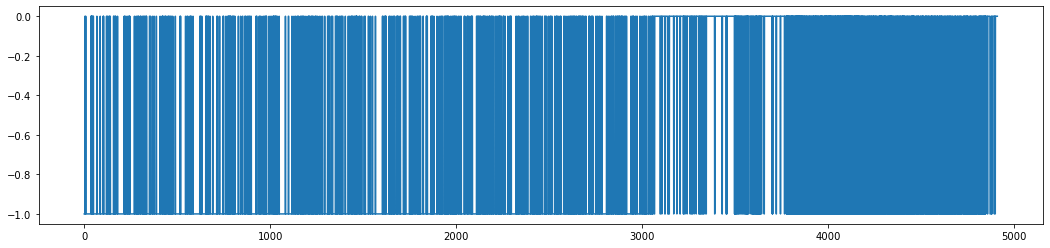

In [130]:
def adjust_rewards_surrogate(reward, state, action):
    reward = pre_processor.process_reward(reward)
    post_processor.collect(state, action, reward)
    reward = post_processor.process_reward(reward)
    reward = post_processor.smooth_reward(state, action, reward)
    return reward

runner(adjust_rewards_noisy)

In [131]:
import pandas as pd

# Q-value of "true" level compared accross different reward techniques

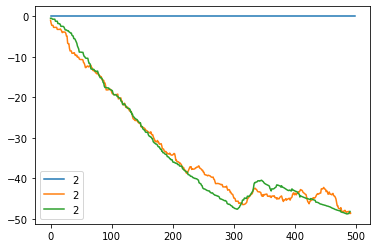

In [132]:
pd.DataFrame([
    pd.DataFrame(all_chart_values[0])[2],
    pd.DataFrame(all_chart_values[1])[2],
    pd.DataFrame(all_chart_values[2])[2],
    ]).T.plot()

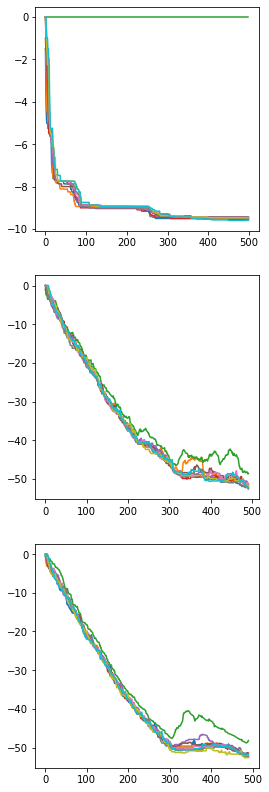

In [133]:
fig = plt.gcf()
fig.set_size_inches(4, 14)
plt.subplot(3, 1, 1)
plt.plot(all_chart_values[0])
plt.subplot(3, 1, 2)
plt.plot(all_chart_values[1])
plt.subplot(3, 1, 3)
plt.plot(all_chart_values[2])


# Custom simplified surrogate rewards

In [134]:
#TODO
# maybe simply removing the epsilon/w/learning rate
# from the original code will give the same simplified result, as described
# in the refernce paper